In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import scipy

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# Configure visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# Data Loading and Initial Inspection

This section loads the original segment and node panels (rich version: accidents by segment/node-year-month + features). The trimmed panel contains only columns that are present in the node panel (acc_* columns).

In [10]:
# Load aggregated risk panels
segment_panel = gpd.read_parquet("../data/merged/berlin_bike_accident_strava_panel.parquet")
segment_panel = segment_panel.rename(columns={"sum_strava_total_trip_count": "monthly_strava_trips"})

node_panel = pd.read_parquet("../data/merged/berlin_bike_accident_node_panel.parquet")

# Print original segment_panel info
print("=== Original Segment Panel ===")
print(f"Shape: {segment_panel.shape}")
print(f"Columns: {segment_panel.columns.tolist()}")

# Remove risk columns from node_panel
risk_cols_to_drop = ['risk_accidents_per_trip', 'risk_accidents_per_10k_trips']
node_panel = node_panel.drop(columns=[col for col in risk_cols_to_drop if col in node_panel.columns])

print("\n=== Node Panel ===")
print(f"Shape: {node_panel.shape}")
print(f"Columns: {node_panel.columns.tolist()}")

# Keep only columns in segment_panel that exist in node_panel
common_cols = [col for col in node_panel.columns if col in segment_panel.columns]
segment_panel_trimmed = segment_panel[['counter_name'] +  common_cols]

print("\n=== Trimmed Segment Panel (aligned to node columns) ===")
print(f"Shape: {segment_panel_trimmed.shape}")
print(f"Columns: {segment_panel_trimmed.columns.tolist()}")

=== Original Segment Panel ===
Shape: (297480, 204)
Columns: ['counter_name', 'year', 'month', 'sum_count', 'monthly_strava_trips', 'sum_strava_ride_count', 'sum_strava_ebike_ride_count', 'sum_strava_total_people_count', 'sum_strava_total_commute_trip_count', 'sum_strava_total_leisure_trip_count', 'sum_strava_total_morning_trip_count', 'sum_strava_total_midday_trip_count', 'sum_strava_total_evening_trip_count', 'sum_strava_total_overnight_trip_count', 'sum_strava_total_male_people_count', 'sum_strava_total_female_people_count', 'sum_strava_total_18_34_people_count', 'sum_strava_total_35_54_people_count', 'sum_strava_total_55_64_people_count', 'sum_strava_total_65_plus_people_count', 'sum_strava_total_unspecified_people_count', 'sum_motorized_vehicle_count_all_vehicles_6km', 'sum_motorized_vehicle_count_cars_6km', 'sum_motorized_vehicle_count_trucks_6km', 'sum_motorized_vehicle_count_all_vehicles', 'sum_motorized_vehicle_count_cars', 'sum_motorized_vehicle_count_trucks', 'mean_strava_to

In [47]:
# Prepare segment and node panels for union
# segment_panel_trimmed: trimmed segment panel
segment_prep = segment_panel_trimmed.copy()
segment_prep['is_node'] = 0
segment_prep = segment_prep.rename(columns={'counter_name': 'id'})

node_prep = node_panel.copy()
node_prep['is_node'] = 1
node_prep = node_prep.rename(columns={'node_id': 'id'})

# Union both panels for further analysis
combined_panel = pd.concat([segment_prep, node_prep], ignore_index=True)

# Remove all columns with acc_injury_severity.., acc_accident_kind, acc_accident_type
cols_to_remove = [col for col in combined_panel.columns if col.startswith('acc_injury_severity') or col.startswith('acc_accident_kind') or col.startswith('acc_accident_type')]
combined_panel = combined_panel.drop(columns=cols_to_remove)

print("=== Combined Panel (segment + node) ===")
print(f"Shape: {combined_panel.shape}")
print(f"Number of segments (is_node=0): {(combined_panel['is_node'] == 0).sum()}")
print(f"Number of nodes (is_node=1): {(combined_panel['is_node'] == 1).sum()}")
print("\nFirst 5 rows:")
display(combined_panel.head())

combined_panel.columns

=== Combined Panel (segment + node) ===
Shape: (474814, 23)
Number of segments (is_node=0): 297480
Number of nodes (is_node=1): 177334

First 5 rows:


,id,year,month,monthly_strava_trips,total_accidents,acc_light_condition_count_0.0,acc_light_condition_count_1.0,acc_light_condition_count_2.0,acc_light_condition_share_0.0,acc_light_condition_share_1.0,...,acc_weekday_type_share_weekday,acc_weekday_type_share_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),acc_time_of_day_share_evening (18h-22h),acc_time_of_day_share_night (22h-7h),acc_time_of_day_share_work_hours (7h-18h),geometry,is_node
0,streetsegment_0,2019,1,75.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,LINESTRING (388283.8938791263 5816533.57797254...,0
1,streetsegment_0,2019,2,110.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (388283.8938791263 5816533.57797254...,0
2,streetsegment_0,2019,3,170.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (388283.8938791263 5816533.57797254...,0
3,streetsegment_0,2019,4,340.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,LINESTRING (388283.8938791263 5816533.57797254...,0
4,streetsegment_0,2019,5,385.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LINESTRING (388283.8938791263 5816533.57797254...,0


Index(['id', 'year', 'month', 'monthly_strava_trips', 'total_accidents',
       'acc_light_condition_count_0.0', 'acc_light_condition_count_1.0',
       'acc_light_condition_count_2.0', 'acc_light_condition_share_0.0',
       'acc_light_condition_share_1.0', 'acc_light_condition_share_2.0',
       'acc_weekday_type_count_weekday', 'acc_weekday_type_count_weekend',
       'acc_weekday_type_share_weekday', 'acc_weekday_type_share_weekend',
       'acc_time_of_day_count_evening (18h-22h)',
       'acc_time_of_day_count_night (22h-7h)',
       'acc_time_of_day_count_work_hours (7h-18h)',
       'acc_time_of_day_share_evening (18h-22h)',
       'acc_time_of_day_share_night (22h-7h)',
       'acc_time_of_day_share_work_hours (7h-18h)', 'geometry', 'is_node'],
      dtype='object')

# Seasonal Aggregation and Wide Format

This section aggregates the combined panel by id, is_node, and season, summing all count and metric columns. It then flattens the seasonal structure into wide format, creating separate columns for accident counts by season. This prepares the data for risk calculation and feature analysis.

In [48]:
# Seasonal aggregation and flattening to wide format
# Group by id, is_node, season and sum all *_count_* and metric columns

temp_df = combined_panel.copy()

# Add season column if not present
if 'season' not in temp_df.columns:
    def month_to_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    temp_df['season'] = temp_df['month'].apply(month_to_season)

# Identify count columns and metrics
count_cols = [c for c in temp_df.columns if '_count_' in c]
metric_cols = ['monthly_strava_trips', 'total_accidents']

# Aggregate by id, is_node, season
combined_panel_seasonal = temp_df.groupby(['id', 'is_node', 'season'], as_index=False)[count_cols + metric_cols].sum()

# Rename trips metric to reflect seasonal aggregation
combined_panel_seasonal = combined_panel_seasonal.rename(columns={'monthly_strava_trips': 'total_strava_trips'})

print(f"=== Combined Seasonal Aggregation ===")
print(f"Original rows: {len(temp_df)}")
print(f"Aggregated (id × is_node × season): {len(combined_panel_seasonal)}")
print(f"Unique elements: {combined_panel_seasonal['id'].nunique()}")
print(f"Segments (is_node=0): {(combined_panel_seasonal['is_node'] == 0).sum()}")
print(f"Nodes (is_node=1): {(combined_panel_seasonal['is_node'] == 1).sum()}")
print(f"Seasons: {sorted(combined_panel_seasonal['season'].unique())}")
print(f"Shape: {combined_panel_seasonal.shape}")
print(f"\nSample:")
display(combined_panel_seasonal.head(12))

# Flatten: create acc_season_<season> columns for total_accidents
seasons = combined_panel_seasonal['season'].unique() if 'season' in combined_panel_seasonal.columns else []
for season in seasons:
    combined_panel_seasonal[f'acc_season_{season}'] = combined_panel_seasonal.apply(
        lambda row: row['total_accidents'] if row['season'] == season else 0, axis=1)

# Sum by id and is_node, drop season
agg_cols = [c for c in combined_panel_seasonal.columns if c.startswith('acc_') or c in ['total_strava_trips', 'total_accidents']]
agg_cols = [c for c in agg_cols if not c.endswith('_share_') and c != 'season']
combined_panel_seasonal_flat = combined_panel_seasonal.groupby(['id', 'is_node'], as_index=False)[agg_cols].sum()

print(f"=== Aggregated by id, is_node (season as columns, total_accidents preserved) ===")
print(f"Shape: {combined_panel_seasonal_flat.shape}")
print(f"Columns: {combined_panel_seasonal_flat.columns.tolist()}")
display(combined_panel_seasonal_flat.head())

=== Combined Seasonal Aggregation ===
Original rows: 474814
Aggregated (id × is_node × season): 31528
Unique elements: 7882
Segments (is_node=0): 19832
Nodes (is_node=1): 11696
Seasons: ['autumn', 'spring', 'summer', 'winter']
Shape: (31528, 13)

Sample:


,id,is_node,season,acc_light_condition_count_0.0,acc_light_condition_count_1.0,acc_light_condition_count_2.0,acc_weekday_type_count_weekday,acc_weekday_type_count_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),total_strava_trips,total_accidents
0,0,1,autumn,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6169.0,1.0
1,0,1,spring,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7275.0,1.0
2,0,1,summer,3.0,0.0,0.0,1.0,2.0,0.0,0.0,3.0,9604.0,3.0
3,0,1,winter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3123.0,0.0
4,1,1,autumn,0.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,12411.0,2.0
5,1,1,spring,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,13635.0,2.0
6,1,1,summer,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,17829.0,4.0
7,1,1,winter,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,6443.0,2.0
8,2,1,autumn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,723.0,0.0
9,2,1,spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,844.0,0.0


=== Aggregated by id, is_node (season as columns, total_accidents preserved) ===
Shape: (7882, 16)
Columns: ['id', 'is_node', 'acc_light_condition_count_0.0', 'acc_light_condition_count_1.0', 'acc_light_condition_count_2.0', 'acc_weekday_type_count_weekday', 'acc_weekday_type_count_weekend', 'acc_time_of_day_count_evening (18h-22h)', 'acc_time_of_day_count_night (22h-7h)', 'acc_time_of_day_count_work_hours (7h-18h)', 'total_strava_trips', 'total_accidents', 'acc_season_autumn', 'acc_season_spring', 'acc_season_summer', 'acc_season_winter']


,id,is_node,acc_light_condition_count_0.0,acc_light_condition_count_1.0,acc_light_condition_count_2.0,acc_weekday_type_count_weekday,acc_weekday_type_count_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),total_strava_trips,total_accidents,acc_season_autumn,acc_season_spring,acc_season_summer,acc_season_winter
0,0,1,5.0,0.0,0.0,3.0,2.0,0.0,0.0,5.0,26171.0,5.0,1.0,1.0,3.0,0.0
1,1,1,7.0,0.0,3.0,8.0,2.0,1.0,1.0,8.0,50318.0,10.0,2.0,2.0,4.0,2.0
2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2997.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3037.0,0.0,0.0,0.0,0.0,0.0


# Feature Importance Analysis

This section evaluates the importance of accident category shares for risk using Spearman correlation (With risk_per_10k_trips)

Segments before trip filter: 7882, after (['total_strava_trips'] >= 200): 7289, lost: 593 (7.5%)
Segments before accident filter: 7289, after (['total_accidents'] >= 5): 1565, lost: 5724 (78.5%)
=== Spearman correlation of *_share_* features with risk (risk_per_10k_trips) ===


,feature,spearman_rho,p_value
1,acc_light_condition_share_1.0,0.066378,0.008622
6,acc_time_of_day_share_night (22h-7h),-0.060438,0.016792
7,acc_time_of_day_share_work_hours (7h-18h),0.058642,0.020340
2,acc_light_condition_share_2.0,-0.049650,0.049552
0,acc_light_condition_share_0.0,0.023425,0.354407
3,acc_weekday_type_share_weekday,0.015408,0.542469
4,acc_weekday_type_share_weekend,-0.015408,0.542469
5,acc_time_of_day_share_evening (18h-22h),-0.004440,0.860692


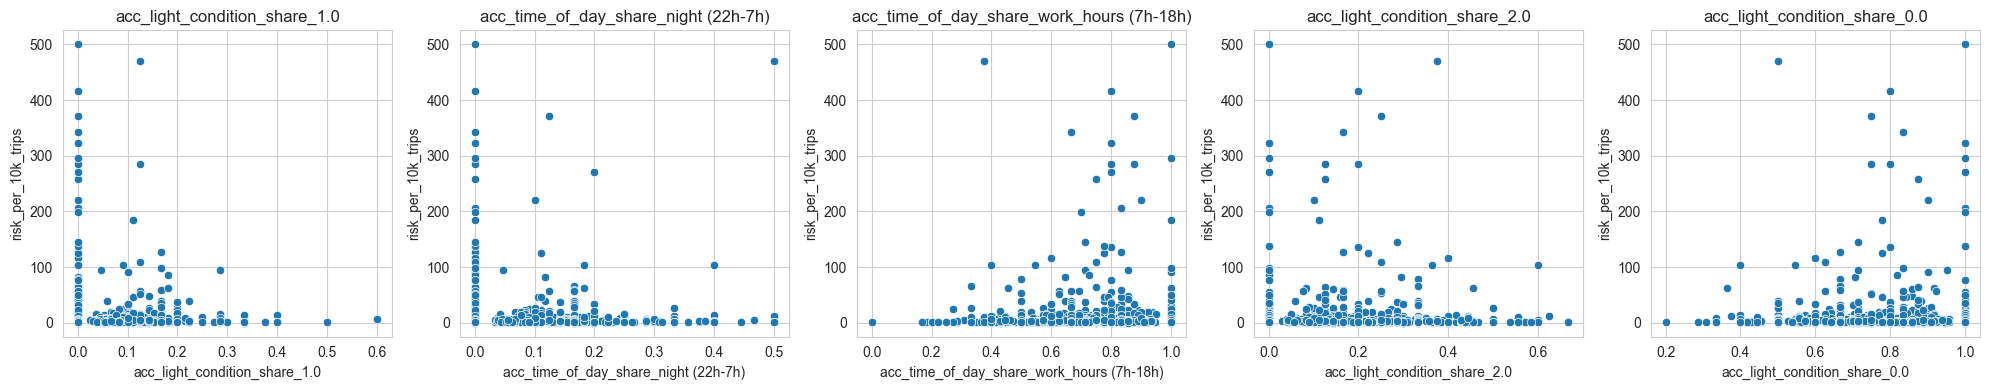

In [53]:
# Calculate risk and feature shares, filter segments
analysis_df = combined_panel_seasonal_flat.copy()

# Filter segments with low traffic
n_before_trips = len(analysis_df)
analysis_df = analysis_df[analysis_df['total_strava_trips'] >= 100].copy()
n_after_trips = len(analysis_df)
print(f"Segments before trip filter: {n_before_trips}, after (['total_strava_trips'] >= 200): {n_after_trips}, lost: {n_before_trips - n_after_trips} ({100*(n_before_trips-n_after_trips)/n_before_trips:.1f}%)")

# Filter segments with low accident count
n_before_acc = len(analysis_df)
analysis_df = analysis_df[analysis_df['total_accidents'] >= 5].copy()
n_after_acc = len(analysis_df)
print(f"Segments before accident filter: {n_before_acc}, after (['total_accidents'] >= 5): {n_after_acc}, lost: {n_before_acc - n_after_acc} ({100*(n_before_acc-n_after_acc)/n_before_acc:.1f}%)")

# Calculate risk per 10k trips
analysis_df['risk_per_10k_trips'] = analysis_df['total_accidents'] / analysis_df['total_strava_trips'].replace({0: np.nan}) * 1e4

# Calculate share for all *_count_* columns as share of total_accidents
count_cols = [c for c in analysis_df.columns if '_count_' in c]
for col in count_cols:
    share_col = col.replace('_count_', '_share_')
    analysis_df[share_col] = analysis_df[col] / analysis_df['total_accidents'].replace({0: np.nan})

# Use only *_share_* columns for correlation analysis
share_cols = [c for c in analysis_df.columns if '_share_' in c]

corrs = []
for col in share_cols:
    rho, pval = scipy.stats.spearmanr(analysis_df[col], analysis_df['risk_per_10k_trips'], nan_policy='omit')
    corrs.append({'feature': col, 'spearman_rho': rho, 'p_value': pval})
corrs_df = pd.DataFrame(corrs).sort_values('spearman_rho', key=abs, ascending=False)

print('=== Spearman correlation of *_share_* features with risk (risk_per_10k_trips) ===')
display(corrs_df)

# Visualize top-5 features
# Scatterplots for the top-5 features with highest absolute correlation
# Each plot shows the relationship between the feature and risk
top5 = corrs_df.head(5)['feature']
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(top5):
    sns.scatterplot(x=analysis_df[col], y=analysis_df['risk_per_10k_trips'], ax=axs[i])
    axs[i].set_title(col)
plt.tight_layout()
plt.show()


# Descriptive Statistics for Categorical Features

This section provides descriptive statistics for each categorical feature in the segment panel. 
All connectivity and infrastructure columns are constant over time per segment, so we can use them directly in aggregated by segment data.

In [30]:
# Convert 'infrastructure_max_speed' categories to integer values (strict: only 0, 10, 20, 30, 40, 50, 60, 70, NaN)
def parse_speed(val):
    if pd.isna(val) or 'nan' in str(val):
        return np.nan
    for s in [0, 10, 20, 30, 40, 50, 60, 70]:
        if str(val) == f'speed_is_{s}.0':
            return s
    return np.nan

segment_panel['infrastructure_max_speed_int'] = segment_panel['infrastructure_max_speed'].apply(parse_speed)

print(segment_panel[['infrastructure_max_speed', 'infrastructure_max_speed_int']].drop_duplicates().sort_values('infrastructure_max_speed_int'))

       infrastructure_max_speed  infrastructure_max_speed_int
300                speed_is_0.0                           0.0
20220             speed_is_10.0                          10.0
240               speed_is_20.0                          20.0
0                 speed_is_30.0                          30.0
130020            speed_is_40.0                          40.0
120               speed_is_50.0                          50.0
2340              speed_is_60.0                          60.0
60300             speed_is_70.0                          70.0
1680               speed_is_nan                           NaN


In [ ]:
# Descriptive statistics for all main categorical features
cat_features = [
    'infrastructure_bicyclelane_type',
    'infrastructure_type_of_street',
    'infrastructure_number_of_street_lanes',
    'infrastructure_street_surface',
    'infrastructure_max_speed',
    'infrastructure_max_speed_int',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network',
]

for col in cat_features:
    print(f'\n=== {col} ===')
    print(f'Unique categories: {segment_panel[col].nunique()}')
    print(segment_panel[col].value_counts())
    stats = segment_panel.groupby(col).agg(
        mean_risk_per_10k_trips=('risk_per_10k_trips', 'mean'),
        mean_accidents=('total_accidents', 'mean'),
        median_accidents=('total_accidents', 'median'),
        count=('risk_per_10k_trips', 'count')
    )
    display(stats.sort_values('mean_risk', ascending=False))


=== infrastructure_bicyclelane_type ===
Unique categories: 3
infrastructure_bicyclelane_type
no bicycle lane             213780
bicycle lane on sidewalk     67200
bicycle lane on street       16500
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_bicyclelane_type,,,,,
no bicycle lane,7.777737,0.0,0.042450,0.0,161159
bicycle lane on sidewalk,3.651184,0.0,0.071057,0.0,65237
bicycle lane on street,2.198354,0.0,0.093818,0.0,16451



=== infrastructure_type_of_street ===
Unique categories: 9
infrastructure_type_of_street
residential     115320
secondary        59700
footway          39300
tertiary         38640
primary          20040
unclassified     10800
path              8820
track             3120
pedestrian        1740
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_type_of_street,,,,,
residential,11.217322,0.0,0.039828,0.0,78030
unclassified,7.304250,0.0,0.021852,0.0,7225
footway,6.211982,0.0,0.036794,0.0,31449
tertiary,5.529127,0.0,0.063794,0.0,36486
pedestrian,3.333876,0.0,0.011494,0.0,1607
path,3.199815,0.0,0.018934,0.0,6919
secondary,2.456616,0.0,0.078275,0.0,59107
primary,1.461058,0.0,0.088573,0.0,19682
track,0.510574,0.0,0.007372,0.0,2342



=== infrastructure_number_of_street_lanes ===
Unique categories: 12
infrastructure_number_of_street_lanes
infrastructure_number_of_street_lanes_isnan     170820
infrastructure_number_of_street_lanes_is2.0      62700
infrastructure_number_of_street_lanes_is4.0      34080
infrastructure_number_of_street_lanes_is6.0      12600
infrastructure_number_of_street_lanes_is1.0       7920
infrastructure_number_of_street_lanes_is3.0       3420
infrastructure_number_of_street_lanes_is8.0       2160
infrastructure_number_of_street_lanes_is0.0       1740
infrastructure_number_of_street_lanes_is5.0        900
infrastructure_number_of_street_lanes_is10.0       840
infrastructure_number_of_street_lanes_is12.0       180
infrastructure_number_of_street_lanes_is7.0        120
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_number_of_street_lanes,,,,,
infrastructure_number_of_street_lanes_isnan,8.740354,0.0,0.035769,0.0,122416
infrastructure_number_of_street_lanes_is1.0,7.637534,0.0,0.060732,0.0,6782
infrastructure_number_of_street_lanes_is2.0,5.037097,0.0,0.069888,0.0,58199
infrastructure_number_of_street_lanes_is3.0,3.714217,0.0,0.068421,0.0,3392
infrastructure_number_of_street_lanes_is0.0,3.333876,0.0,0.011494,0.0,1607
infrastructure_number_of_street_lanes_is6.0,2.045073,0.0,0.086429,0.0,12461
infrastructure_number_of_street_lanes_is4.0,1.914382,0.0,0.082981,0.0,33801
infrastructure_number_of_street_lanes_is8.0,1.684105,0.0,0.059259,0.0,2149
infrastructure_number_of_street_lanes_is5.0,0.650135,0.0,0.093333,0.0,900



=== infrastructure_street_surface ===
Unique categories: 22
infrastructure_street_surface
asphalt                  211320
sett                      23220
paving_stones             22020
concrete                  16020
unclassified              11100
compacted                  4380
fine_gravel                2280
dirt                       1560
ground                     1320
cobblestone                1200
concrete:plates             780
gravel                      480
sand                        360
wood                        240
cobblestone:flattened       240
unhewn_cobblestone          240
grass                       180
paved                       180
pebblestone                 120
earth                       120
unpaved                      60
grass_paver                  60
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_street_surface,,,,,
sett,12.160750,0.0,0.030146,0.0,12902
concrete:plates,9.808644,0.0,0.037179,0.0,563
concrete,8.641176,0.0,0.024282,0.0,9992
paving_stones,8.257073,0.0,0.044641,0.0,17501
ground,7.895379,0.0,0.028788,0.0,790
gravel,7.558773,0.0,0.012500,0.0,290
unclassified,6.639109,0.0,0.016847,0.0,5849
asphalt,5.689449,0.0,0.061163,0.0,187080
cobblestone,3.752633,0.0,0.006667,0.0,579



=== infrastructure_max_speed ===
Unique categories: 9
infrastructure_max_speed
speed_is_30.0    128400
speed_is_50.0    106680
speed_is_0.0      52860
speed_is_nan       6000
speed_is_60.0      1800
speed_is_20.0       840
speed_is_10.0       480
speed_is_70.0       360
speed_is_40.0        60
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_max_speed,,,,,
speed_is_30.0,10.069585,0.0,0.045265,0.0,90794
speed_is_nan,7.516277,0.0,0.012667,0.0,3092
speed_is_0.0,5.303068,0.0,0.031309,0.0,42239
speed_is_20.0,4.214611,0.0,0.030952,0.0,638
speed_is_50.0,3.450872,0.0,0.072188,0.0,103775
speed_is_60.0,3.148570,0.0,0.058889,0.0,1729
speed_is_40.0,0.231831,0.0,0.066667,0.0,60
speed_is_10.0,0.117096,0.0,0.002083,0.0,280
speed_is_70.0,0.089477,0.0,0.047222,0.0,240



=== infrastructure_max_speed_int ===
Unique categories: 8
infrastructure_max_speed_int
30.0    128400
50.0    106680
0.0      52860
60.0      1800
20.0       840
10.0       480
70.0       360
40.0        60
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_max_speed_int,,,,,
30.0,10.069585,0.0,0.045265,0.0,90794
0.0,5.303068,0.0,0.031309,0.0,42239
20.0,4.214611,0.0,0.030952,0.0,638
50.0,3.450872,0.0,0.072188,0.0,103775
60.0,3.148570,0.0,0.058889,0.0,1729
40.0,0.231831,0.0,0.066667,0.0,60
10.0,0.117096,0.0,0.002083,0.0,280
70.0,0.089477,0.0,0.047222,0.0,240



=== infrastructure_is_within_cyclingroute ===
Unique categories: 2
infrastructure_is_within_cyclingroute
False    261600
True      35880
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
infrastructure_is_within_cyclingroute,,,,,
False,7.045057,0.0,0.049767,0.0,207856
True,1.813392,0.0,0.066304,0.0,34991



=== connectivity_is_cycling_main_network ===
Unique categories: 2
connectivity_is_cycling_main_network
False    176880
True     120600
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
connectivity_is_cycling_main_network,,,,,
False,7.548917,0.0,0.045370,0.0,134721
True,4.724230,0.0,0.061136,0.0,108126



=== connectivity_is_cycling_minor_network ===
Unique categories: 2
connectivity_is_cycling_minor_network
True     176880
False    120600
Name: count, dtype: int64


,mean_risk,median_risk,mean_accidents,median_accidents,count
connectivity_is_cycling_minor_network,,,,,
True,7.548917,0.0,0.045370,0.0,134721
False,4.724230,0.0,0.061136,0.0,108126


In [37]:
# Regression analysis: effect of categorical features on risk
import statsmodels.formula.api as smf

# Filter: only segments with at least 100 monthly_strava_trips
reg_df = segment_panel[
    (segment_panel['monthly_strava_trips'] >= 100)
][[
    'risk_per_10k_trips',
    'infrastructure_bicyclelane_type',
    'infrastructure_type_of_street',
    'infrastructure_number_of_street_lanes',
    'infrastructure_street_surface',
    'infrastructure_max_speed_int',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network'
]].dropna()

# Prepare formula with all main categorical features as factors
formula = (
    'risk_per_10k_trips ~ '
    'C(infrastructure_bicyclelane_type) + '
    'C(infrastructure_type_of_street) + '
    'C(infrastructure_number_of_street_lanes) + '
    'C(infrastructure_street_surface) + '
    'infrastructure_max_speed_int + '
    'C(infrastructure_is_within_cyclingroute) + '
    'C(connectivity_is_cycling_main_network) + '
    'C(connectivity_is_cycling_minor_network)'
)

model = smf.ols(formula, data=reg_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     risk_per_10k_trips   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     20.90
Date:                Sat, 17 Jan 2026   Prob (F-statistic):          2.17e-156
Time:                        20:49:08   Log-Likelihood:            -5.8462e+05
No. Observations:              162768   AIC:                         1.169e+06
Df Residuals:                  162725   BIC:                         1.170e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

## Regression Analysis

We fit OLS, Poisson, and Negative Binomial regression models to quantify the effect of categorical features on risk and accident counts. The results show which features are statistically significant predictors, but the overall explanatory power is low.

In [43]:
# Poisson regression: effect of categorical features on accident count (with exposure)
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Filter: only segments with at least 100 monthly_strava_trips and >0 trips
poisson_df = segment_panel[
    (segment_panel['monthly_strava_trips'] >= 100) &
    (segment_panel['monthly_strava_trips'] > 0)
][[
    'total_accidents',
    'monthly_strava_trips',
    'infrastructure_bicyclelane_type',
    'infrastructure_type_of_street',
    'infrastructure_number_of_street_lanes',
    'infrastructure_street_surface',
    'infrastructure_max_speed_int',
    'infrastructure_is_within_cyclingroute',
    'connectivity_is_cycling_main_network',
    'connectivity_is_cycling_minor_network'
]].dropna()

poisson_formula = (
    'total_accidents ~ '
    'C(infrastructure_bicyclelane_type) + '
    'C(infrastructure_type_of_street) + '
    'C(infrastructure_number_of_street_lanes) + '
    'C(infrastructure_street_surface) + '
    'infrastructure_max_speed_int + '
    'C(infrastructure_is_within_cyclingroute) + '
    'C(connectivity_is_cycling_main_network) + '
    'C(connectivity_is_cycling_minor_network)'
)

poisson_model = smf.glm(
    formula=poisson_formula,
    data=poisson_df,
    family=sm.families.Poisson(),
    offset=np.log(poisson_df['monthly_strava_trips'])
).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        total_accidents   No. Observations:               162768
Model:                            GLM   Df Residuals:                   162725
Model Family:                 Poisson   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44947.
Date:                Sat, 17 Jan 2026   Deviance:                       66804.
Time:                        20:57:32   Pearson chi2:                 2.68e+05
No. Iterations:                    22   Pseudo R-squ. (CS):            0.01960
Covariance Type:            nonrobust                                         
                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

### Why Negative Binomial Regression?

Negative Binomial regression is well-suited for our data because accident counts have many zeros (zero-inflation), and there is strong heterogeneity in exposure: some segments have very low traffic, others very high. This leads to overdispersion and excess zeros, which the Negative Binomial model can handle much better than Poisson regression.

In [52]:
# ================================
# Negative Binomial accident model
# with exposure offset (FULL CELL)
# ================================

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf


# ----------------
# 1. Data filtering
# ----------------

nb_df = (
    segment_panel
    .loc[
        (segment_panel['monthly_strava_trips'] > 0) &
        (segment_panel['monthly_strava_trips'] >= 100),
        [
            'total_accidents',
            'monthly_strava_trips',

            # Infrastructure
            'infrastructure_bicyclelane_type',
            'infrastructure_type_of_street',
            'infrastructure_number_of_street_lanes',
            'infrastructure_street_surface',
            'infrastructure_max_speed_int',
            'infrastructure_is_within_cyclingroute',

            # Connectivity
            'connectivity_is_cycling_main_network',
            'connectivity_is_cycling_minor_network'
        ]
    ]
    .dropna()
    .copy()
)

# Sanity checks
assert (nb_df['monthly_strava_trips'] > 0).all(), "Zero exposure found"
assert (nb_df['total_accidents'] >= 0).all(), "Negative accident counts found"


# ----------------
# 2. Model formula
# ----------------
# IMPORTANT:
# Traffic is NOT included as a regressor.
# It is used ONLY as a log-offset.

nb_formula = """
total_accidents ~
    C(infrastructure_bicyclelane_type) +
    C(infrastructure_type_of_street) +
    C(infrastructure_number_of_street_lanes) +
    C(infrastructure_street_surface) +
    infrastructure_max_speed_int +
    C(infrastructure_is_within_cyclingroute) +
    C(connectivity_is_cycling_main_network) +
    C(connectivity_is_cycling_minor_network)
"""


# ----------------
# 3. Fit NB GLM
# ----------------

nb_model = smf.glm(
    formula=nb_formula,
    data=nb_df,
    family=sm.families.NegativeBinomial(),
    offset=np.log(nb_df['monthly_strava_trips'])
).fit()

print(nb_model.summary())


# ----------------
# 4. Overdispersion check
# ----------------

dispersion = nb_model.pearson_chi2 / nb_model.df_resid
print(f"\nDispersion statistic (Pearson χ² / df): {dispersion:.2f}")


# ----------------
# 5. IRR + 95% CI
# ----------------

irr = np.exp(nb_model.params)

ci = np.exp(nb_model.conf_int())
ci.columns = ['IRR_2.5%', 'IRR_97.5%']

results_table = (
    pd.concat([irr, ci], axis=1)
    .rename(columns={0: 'IRR'})
    .sort_values('IRR', ascending=False)
)

print("\nIncidence Rate Ratios (IRR) with 95% CI:")
display(results_table)


# ----------------
# 6. Segment risk scores
# ----------------

# Expected accident count at observed exposure
nb_df['expected_accidents'] = nb_model.predict(nb_df)

# Normalized risk: accidents per trip
nb_df['risk_per_trip'] = (
    nb_df['expected_accidents'] /
    nb_df['monthly_strava_trips']
)

print("\nRisk per trip summary:")
display(nb_df[['expected_accidents', 'risk_per_trip']].describe())


/Users/laysan/Desktop/University/data_literacy_/data_literacy/venv/lib/python3.14/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:        total_accidents   No. Observations:               162768
Model:                            GLM   Df Residuals:                   162725
Model Family:        NegativeBinomial   Df Model:                           42
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44422.
Date:                Sat, 17 Jan 2026   Deviance:                       56605.
Time:                        22:07:28   Pearson chi2:                 2.44e+05
No. Iterations:                    22   Pseudo R-squ. (CS):            0.01684
Covariance Type:            nonrobust                                         
                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

/Users/laysan/Desktop/University/data_literacy_/data_literacy/venv/lib/python3.14/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,IRR,IRR_2.5%,IRR_97.5%
C(infrastructure_street_surface)[T.ground],6.171088e+00,4.062422,9.374290
C(infrastructure_type_of_street)[T.residential],3.946455e+00,3.417520,4.557254
C(infrastructure_type_of_street)[T.tertiary],3.664092e+00,3.093958,4.339287
C(infrastructure_type_of_street)[T.unclassified],3.098137e+00,2.402083,3.995886
C(infrastructure_type_of_street)[T.secondary],3.096880e+00,2.600608,3.687854
C(infrastructure_street_surface)[T.pebblestone],2.682524e+00,1.147868,6.268956
C(infrastructure_type_of_street)[T.primary],2.448003e+00,2.037366,2.941406
C(infrastructure_street_surface)[T.sand],2.425289e+00,1.098860,5.352841
C(infrastructure_street_surface)[T.paving_stones],2.033785e+00,1.784319,2.318130
C(infrastructure_street_surface)[T.gravel],1.652626e+00,0.584886,4.669582



Risk per trip summary:


,expected_accidents,risk_per_trip
count,1.627680e+05,1.627680e+05
mean,1.246495e-04,4.148707e-07
std,4.990191e-05,4.163364e-07
min,4.152927e-14,6.018735e-17
25%,9.775247e-05,1.130347e-07
50%,1.249773e-04,2.651493e-07
75%,1.553521e-04,5.825278e-07
max,4.507269e-04,4.507269e-06
